# Load libraries

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import data & Merge 

In [99]:
#Sales data
umsatzdaten_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/refs/heads/main/umsatzdaten_gekuerzt.csv"
umsatzdaten = pd.read_csv(umsatzdaten_url)

#Weather data
wetter_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/refs/heads/main/wetter.csv"
wetter =pd.read_csv(wetter_url)

#Kieler woche data
kiwo_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/refs/heads/main/kiwo.csv"
kiwo = pd.read_csv(kiwo_url)

# Ensure date format is consistent
umsatzdaten["Datum"] = pd.to_datetime(umsatzdaten["Datum"])
kiwo["Datum"] = pd.to_datetime(kiwo["Datum"])
wetter["Datum"] = pd.to_datetime(wetter["Datum"])


# Reshape 'umsatz' so that no duplicate 'Datum' exists
umsatz = umsatzdaten.pivot_table(
    index="Datum", columns="Warengruppe", values="Umsatz", aggfunc="sum"
).reset_index()

# Rename columns to match the desired format
umsatz.columns = ["Datum"] + [f"Umsatz_WG_{i}" for i in range(1, len(umsatz.columns))]

# Fill NaN values with 0
umsatz.fillna(0, inplace=True)

# Merge the DataFrames on the 'Datum' column
merged_df = umsatz.merge(kiwo, on="Datum", how="left").merge(wetter, on="Datum", how="left")

# in 'KielerWoche' fill NaN values  with 0
merged_df["KielerWoche"] = merged_df["KielerWoche"].fillna(0)    #0 = no Kieler Woche, 1 = Kieler Woche

# Ensure 'Datum' to datetime and extract the year, day of the year, and weekday
merged_df["Datum"] = pd.to_datetime(merged_df["Datum"])


#Constructing new variables for later use
merged_df['Jahr'] = merged_df['Datum'].dt.year
merged_df['Monat'] = merged_df['Datum'].dt.month
merged_df['Tag_im_Jahr'] = merged_df['Datum'].dt.dayofyear
merged_df["Wochentag"] = merged_df['Datum'].dt.weekday + 1  # 1=Monday, 7=Sunday





print(merged_df.head())


#Checking the data types
print("\nData types:")
print(merged_df.dtypes)


#Transforming the data
# Convert some variables to categorical? 

# Convert weekday to ordered categorical
weekday_order = [1, 2, 3, 4, 5, 6, 7]  # Monday=1, Sunday=7
merged_df["Wochentag"] = pd.Categorical(merged_df["Wochentag"], categories=weekday_order, ordered=True)
print(merged_df["Wochentag"].dtype)



       Datum  Umsatz_WG_1  Umsatz_WG_2  Umsatz_WG_3  Umsatz_WG_4  Umsatz_WG_5  \
0 2013-07-01   148.828353   535.856285   201.198426    65.890169   317.475875   
1 2013-07-02   159.793757   546.780787   265.261254    74.543917   383.628682   
2 2013-07-03   111.885594   427.343259   210.260241    69.262728   305.523072   
3 2013-07-04   168.864941   454.859641   190.686641    61.490175   308.408168   
4 2013-07-05   171.280754   492.818804   181.644870    86.759861   355.518770   

   Umsatz_WG_6  KielerWoche  Bewoelkung  Temperatur  Windgeschwindigkeit  \
0          0.0          0.0         6.0     17.8375                 15.0   
1          0.0          0.0         3.0     17.3125                 10.0   
2          0.0          0.0         7.0     21.0750                  6.0   
3          0.0          0.0         7.0     18.8500                  7.0   
4          0.0          0.0         5.0     19.9750                 12.0   

   Wettercode  Jahr  Monat  Tag_im_Jahr  Wochentag  
0  

# Missing values

In [100]:
print("\nMissing values per column:")
print(merged_df.isnull().sum())



Missing values per column:
Datum                    0
Umsatz_WG_1              0
Umsatz_WG_2              0
Umsatz_WG_3              0
Umsatz_WG_4              0
Umsatz_WG_5              0
Umsatz_WG_6              0
KielerWoche              0
Bewoelkung              12
Temperatur               3
Windgeschwindigkeit      3
Wettercode             459
Jahr                     0
Monat                    0
Tag_im_Jahr              0
Wochentag                0
dtype: int64


# Feature Distributions
Quick visualization of the distributions of the variables. Attention! this is for all the data altogether + we need to convert some variables to categorical 

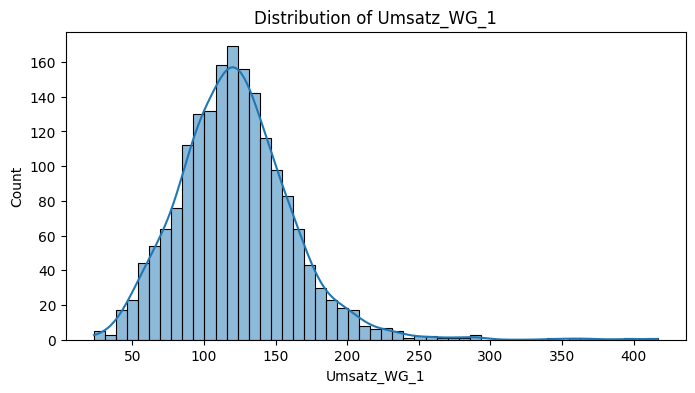

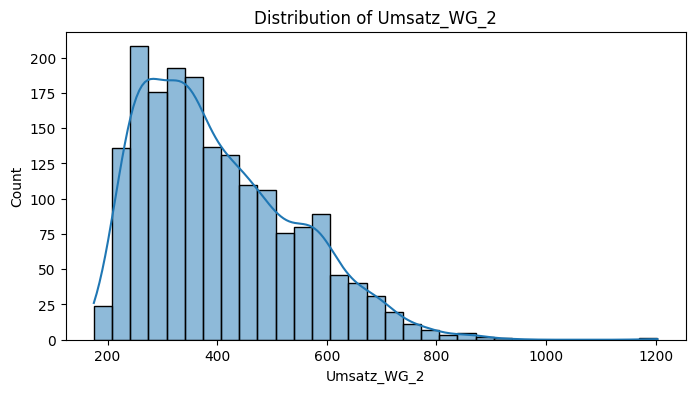

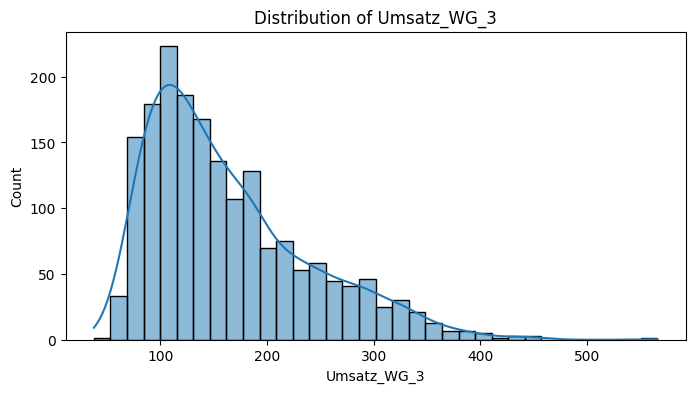

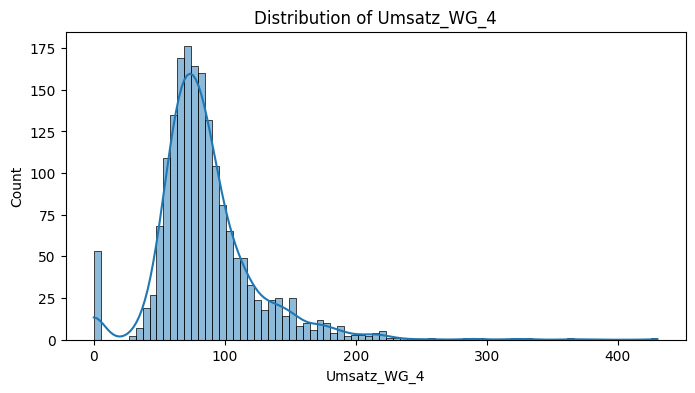

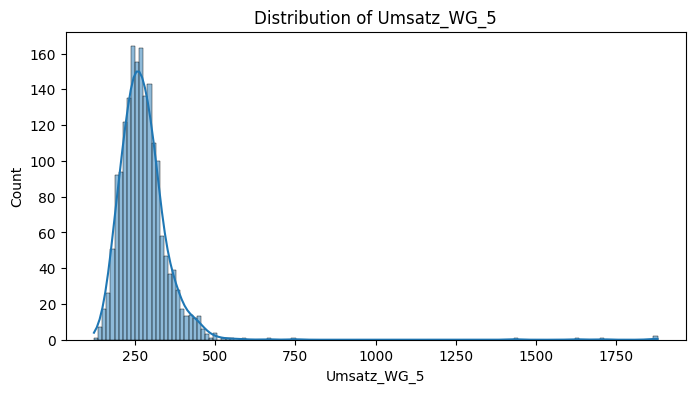

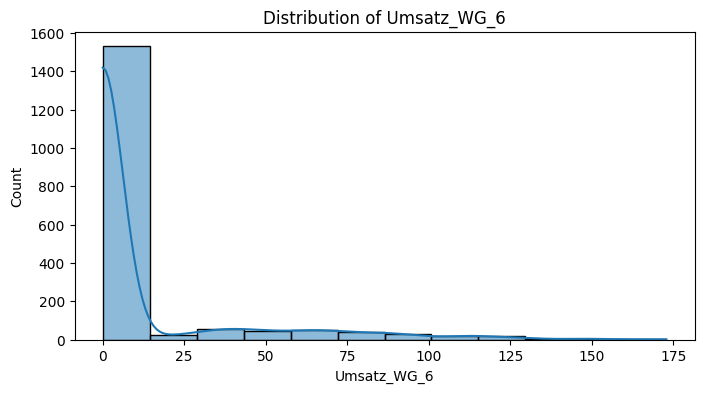

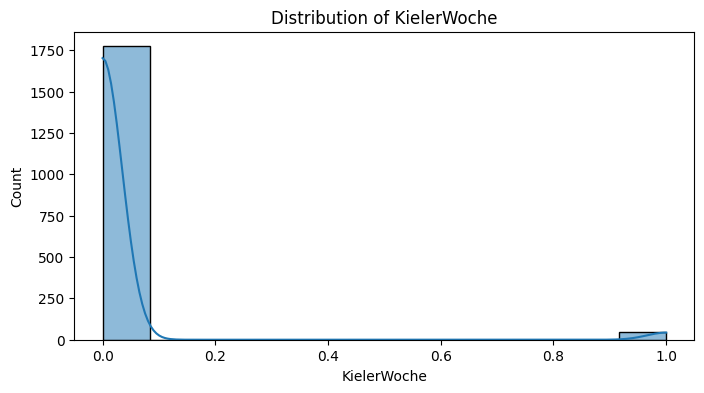

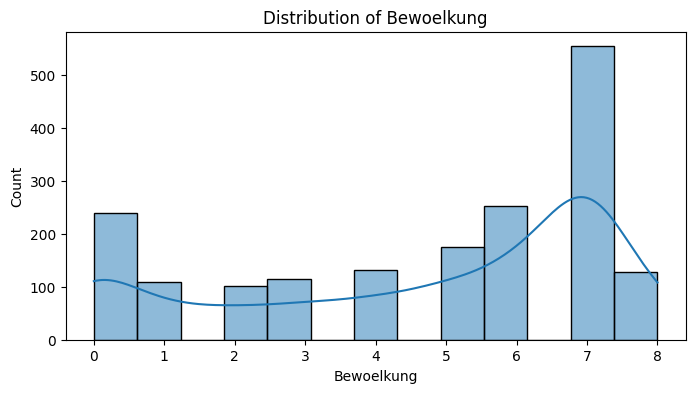

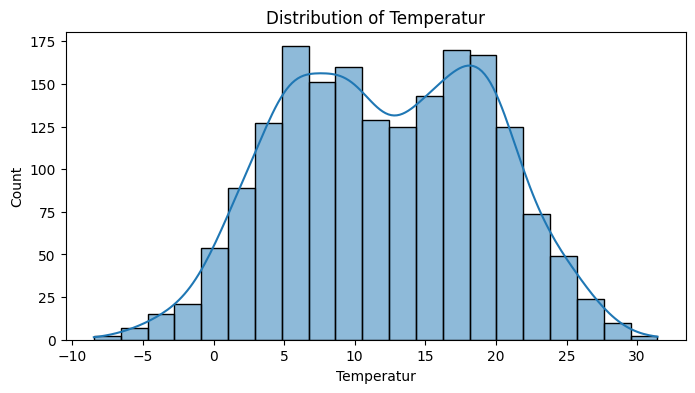

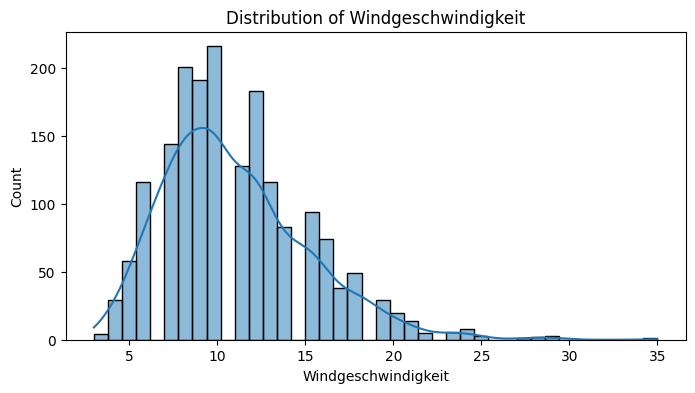

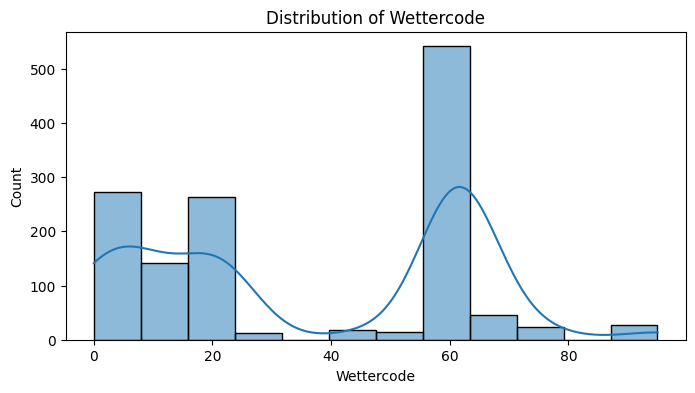

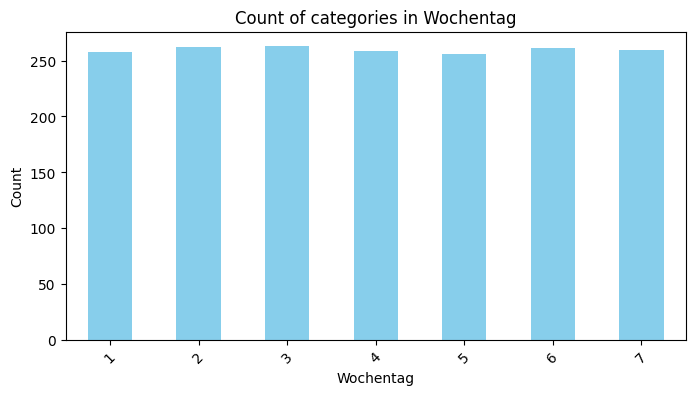

In [102]:

numerical_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(merged_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()



categorical_cols = merged_df.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    plt.figure(figsize=(8, 4))

       # Ensure correct order for categorical columns
    if merged_df[col].dtype.name == 'category':
        merged_df[col] = merged_df[col].cat.set_categories(merged_df[col].cat.categories, ordered=True)

    # Plot bar chart with the correct order of categories
    merged_df[col].value_counts().sort_index().plot(kind='bar', color='skyblue')
    
    plt.title(f'Count of categories in {col}')
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.show()

# Check data
#1.See total days per year:                                   to see if our years have comparable days\
#2. Abacus plot to see the distribution of days in the year : last year doesnt have a kiwo!!!\
#3. Distribution of temperature                             : to see if the pattern is the expected - it is!



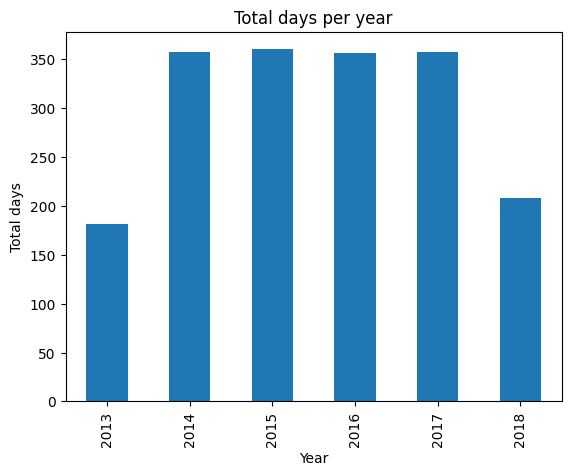

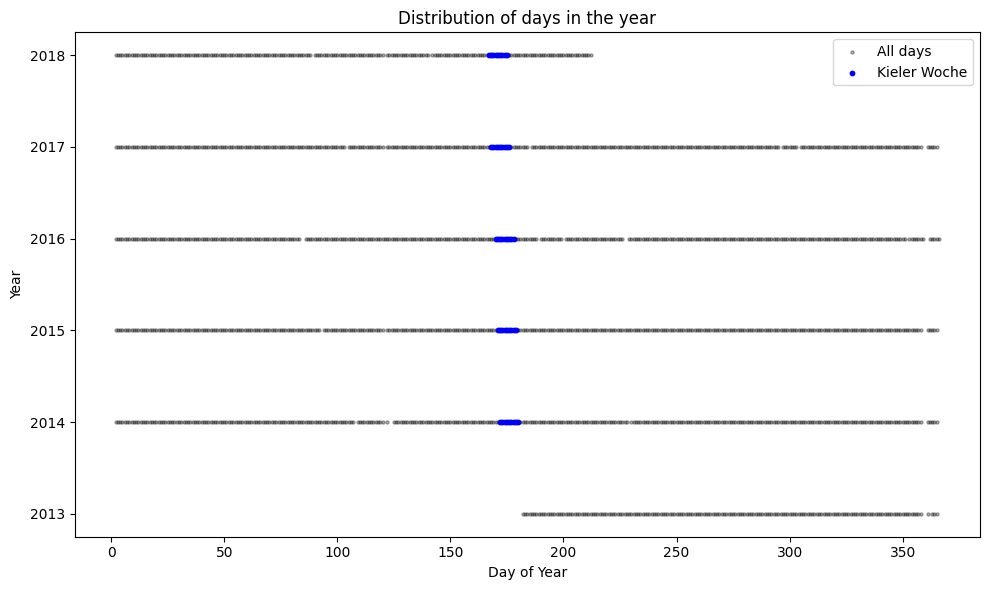

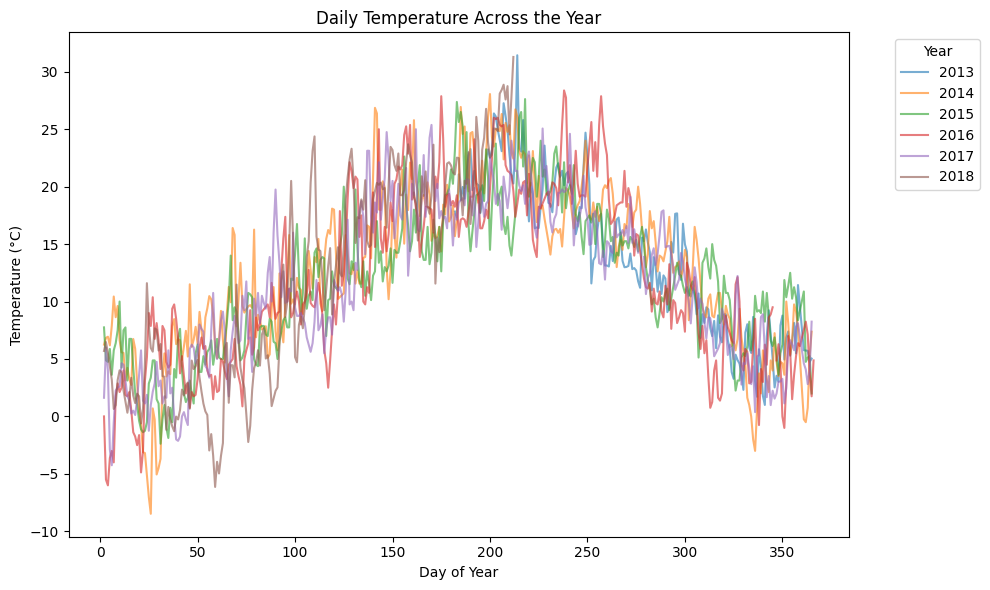

In [71]:
#1.See total days per year
merged_df['Jahr'].value_counts().sort_index().plot(kind='bar')
plt.title("Total days per year")
plt.xlabel("Year")
plt.ylabel("Total days")      

#2. Abacus plot to see the distribution of days in the year
# Filter for Kieler Woche days
kiwo_days = merged_df[merged_df["KielerWoche"] == 1]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot all days in black
for year in sorted(merged_df["Jahr"].unique()):
    days = merged_df[merged_df["Jahr"] == year]["Tag_im_Jahr"]
    plt.scatter(days, [year] * len(days), color="black", s=5, alpha=0.3, label="All days" if year == merged_df["Jahr"].min() else "")

# Overlay Kieler Woche days in blue
kiwo_days = merged_df[merged_df["KielerWoche"] == 1]
for year in sorted(kiwo_days["Jahr"].unique()):
    days = kiwo_days[kiwo_days["Jahr"] == year]["Tag_im_Jahr"]
    plt.scatter(days, [year] * len(days), color="blue", s=10, label="Kieler Woche" if year == kiwo_days["Jahr"].min() else "")

# Labels, title, legend
plt.xlabel("Day of Year")
plt.ylabel("Year")
plt.title("Distribution of days in the year")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

#3. Distribution of temperature   

# Plot
plt.figure(figsize=(10, 6))

for year, data in merged_df.groupby('Jahr'):
    plt.plot(data['Tag_im_Jahr'], data['Temperatur'], label=year, alpha=0.6)

plt.title("Daily Temperature Across the Year")
plt.xlabel("Day of Year")
plt.ylabel("Temperature (°C)")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()









# Sales 
Did that to detecct special days eg. Christmas, Easter and to see if that is consistent throughout the years

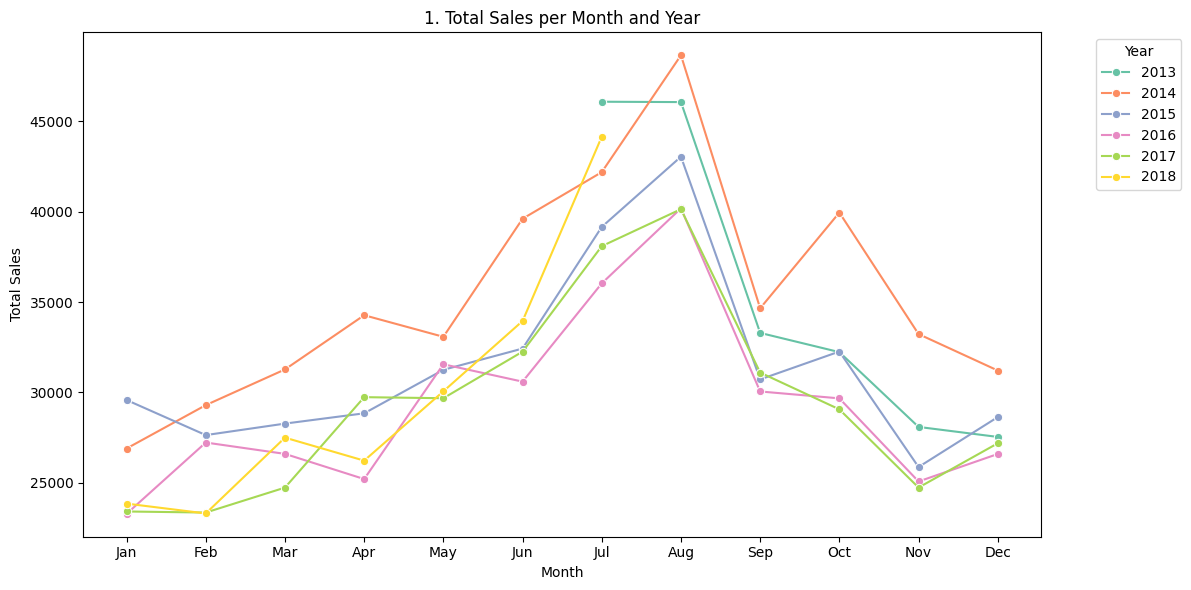

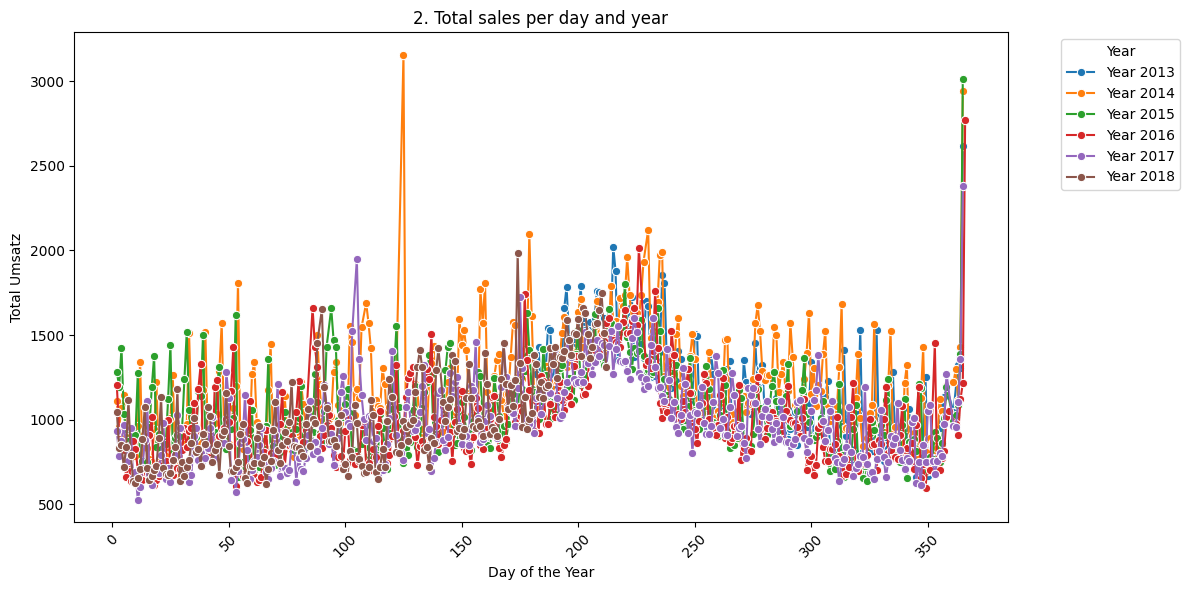

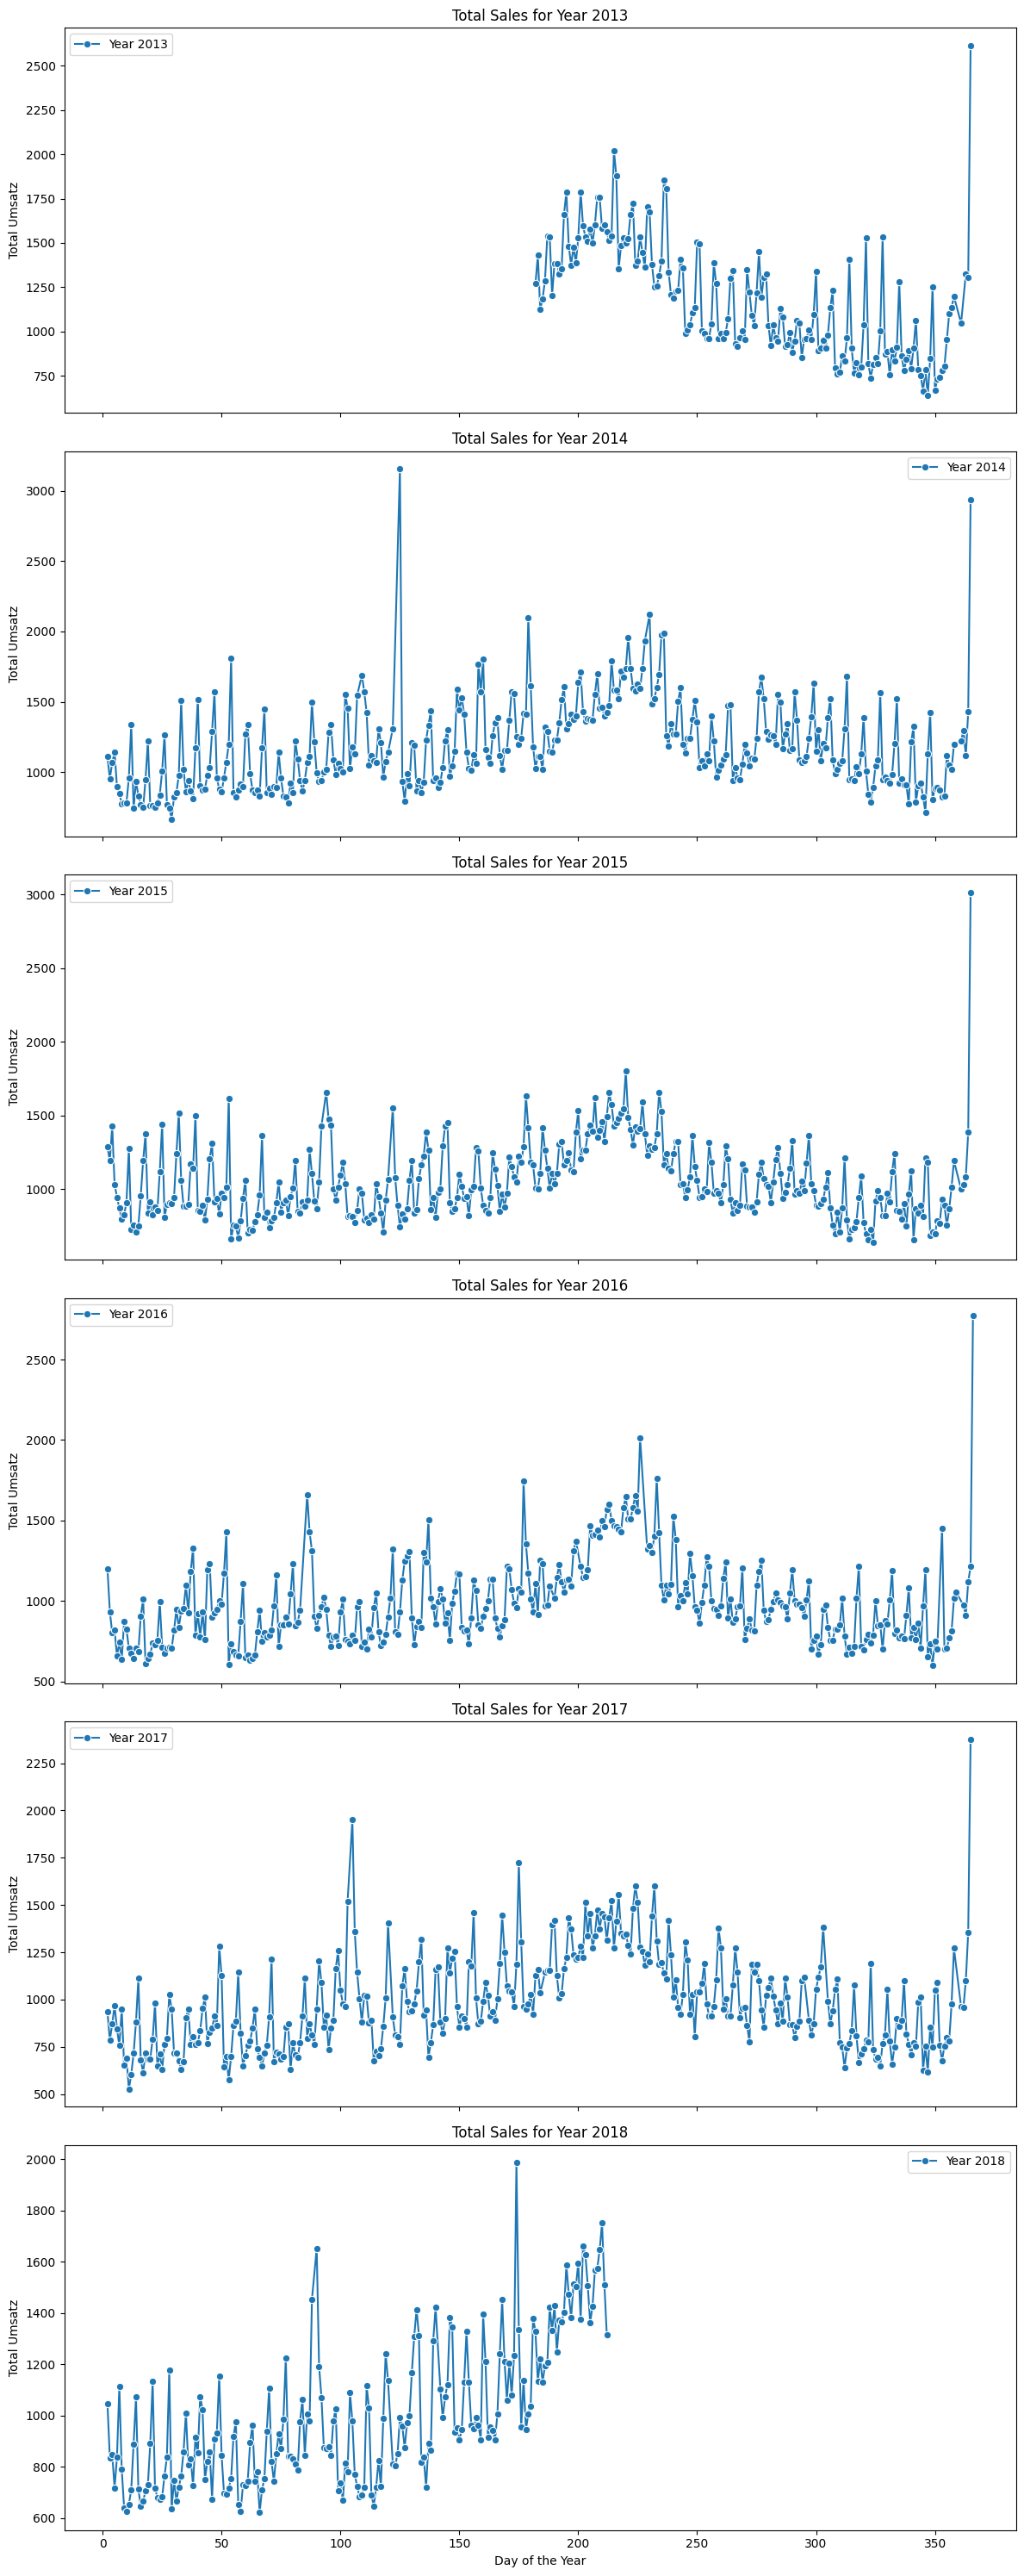

In [72]:
#1. Total sales per month and year

# Sum the sales for each 'Umsatz_WG_1' to 'Umsatz_WG_6' per month and year
umsatz_per_month_year = merged_df.groupby(['Jahr', 'Monat'])[['Umsatz_WG_1', 'Umsatz_WG_2', 'Umsatz_WG_3', 'Umsatz_WG_4', 'Umsatz_WG_5', 'Umsatz_WG_6']].sum().reset_index()

# Sum across all Umsatz_WG_ columns to get total sales per month and year
umsatz_per_month_year['Total_Umsatz'] = umsatz_per_month_year[['Umsatz_WG_1', 'Umsatz_WG_2', 'Umsatz_WG_3', 'Umsatz_WG_4', 'Umsatz_WG_5', 'Umsatz_WG_6']].sum(axis=1)

# Plotting the total sales for each month and year
plt.figure(figsize=(12, 6))
sns.lineplot(data=umsatz_per_month_year, x='Monat', y='Total_Umsatz', hue='Jahr', marker='o', palette='Set2')

# Customize the plot
plt.title('1. Total Sales per Month and Year')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


#2. Total sales per day and year

#Same plot but all years in the same plot
umsatz_per_day_year = merged_df.groupby(['Jahr', 'Monat', 'Tag_im_Jahr'])[['Umsatz_WG_1', 'Umsatz_WG_2', 'Umsatz_WG_3', 'Umsatz_WG_4', 'Umsatz_WG_5', 'Umsatz_WG_6']].sum().reset_index()

# Sum across all Umsatz_WG_ columns to get total sales per day
umsatz_per_day_year['Total_Umsatz'] = umsatz_per_day_year[['Umsatz_WG_1', 'Umsatz_WG_2', 'Umsatz_WG_3', 'Umsatz_WG_4', 'Umsatz_WG_5', 'Umsatz_WG_6']].sum(axis=1)

# Plotting total sales for each day, year by year in separate subplots using line plots
years = umsatz_per_day_year['Jahr'].unique()

plt.figure(figsize=(12, 6))  # Adjust overall figure size

# Plotting the sales for each year in the same figure, with the same x-axis
for year in years:
    year_data = umsatz_per_day_year[umsatz_per_day_year['Jahr'] == year]
    sns.lineplot(data=year_data, x='Tag_im_Jahr', y='Total_Umsatz', label=f'Year {year}', marker='o')

# Customize the overall plot
plt.title('2. Total sales per day and year')
plt.xlabel('Day of the Year')
plt.ylabel('Total Umsatz')
plt.xticks(rotation=45)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show plot
plt.show()


#3. Plotting total sales for each day, year by year in separate subplots 

# Sum the sales for each 'Jahr', 'Monat', and 'Tag_im_Jahr'
umsatz_per_day_year = merged_df.groupby(['Jahr', 'Monat', 'Tag_im_Jahr'])[['Umsatz_WG_1', 'Umsatz_WG_2', 'Umsatz_WG_3', 'Umsatz_WG_4', 'Umsatz_WG_5', 'Umsatz_WG_6']].sum().reset_index()

# Sum across all Umsatz_WG_ columns to get total sales per day
umsatz_per_day_year['Total_Umsatz'] = umsatz_per_day_year[['Umsatz_WG_1', 'Umsatz_WG_2', 'Umsatz_WG_3', 'Umsatz_WG_4', 'Umsatz_WG_5', 'Umsatz_WG_6']].sum(axis=1)

# Get unique years for plotting
years = umsatz_per_day_year['Jahr'].unique()
num_years = len(years)

# Create subplots with shared x-axis
fig, axes = plt.subplots(num_years, 1, figsize=(12, num_years * 5), sharex=True)

# Plotting the sales for each year in separate subplots
for i, year in enumerate(years):
    year_data = umsatz_per_day_year[umsatz_per_day_year['Jahr'] == year]
    sns.lineplot(data=year_data, x='Tag_im_Jahr', y='Total_Umsatz', ax=axes[i], marker='o', label=f'Year {year}')
    
    # Customize each subplot
    axes[i].set_title(f'Total Sales for Year {year}')
    axes[i].set_xlabel('Day of the Year')
    axes[i].set_ylabel('Total Umsatz')
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


# Distribution of different Warengruppen 
Did that to see if there is a trend in the sales of the different groups, if that is consistent between the years, for example group 2 is always best seller, followed by group 5. Attention! different y axes!

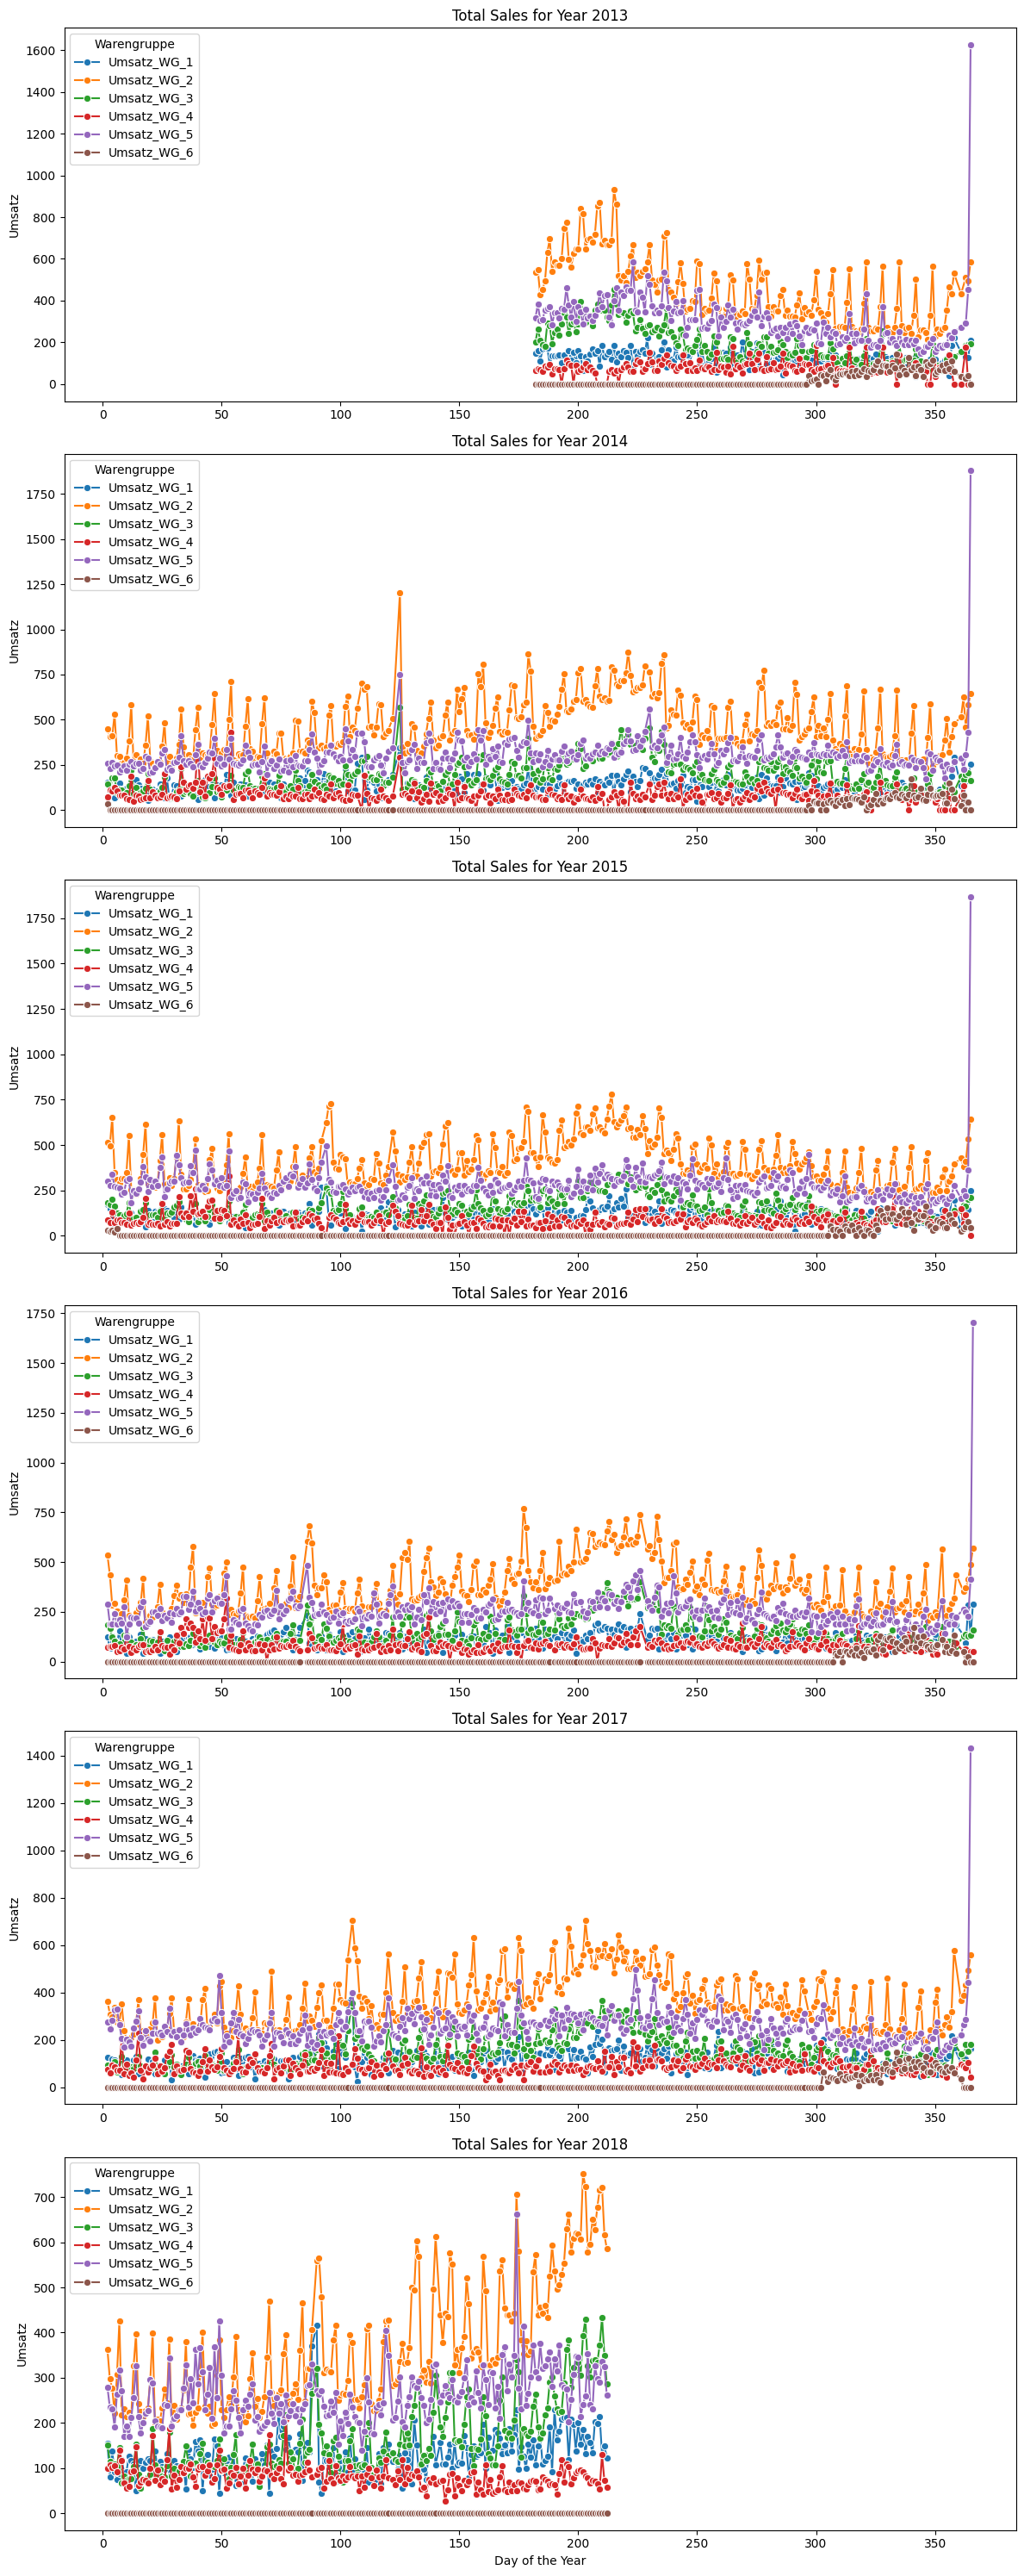

In [73]:


# Sum the sales for each 'Jahr', 'Monat', and 'Tag_im_Jahr'
umsatz_per_day_year = merged_df.groupby(['Jahr', 'Monat', 'Tag_im_Jahr'])[['Umsatz_WG_1', 'Umsatz_WG_2', 'Umsatz_WG_3', 'Umsatz_WG_4', 'Umsatz_WG_5', 'Umsatz_WG_6']].sum().reset_index()

# Plotting total sales for each Umsatz_WG_ column per day, year by year in separate subplots
years = umsatz_per_day_year['Jahr'].unique()
num_years = len(years)

# Create subplots with shared x-axis
fig, axes = plt.subplots(num_years, 1, figsize=(12, num_years * 5), sharex=True)

# List of Umsatz_WG_ columns to plot
umsatz_cols = ['Umsatz_WG_1', 'Umsatz_WG_2', 'Umsatz_WG_3', 'Umsatz_WG_4', 'Umsatz_WG_5', 'Umsatz_WG_6']

# Plotting the sales for each Umsatz_WG_ column in separate subplots
for i, year in enumerate(years):
    year_data = umsatz_per_day_year[umsatz_per_day_year['Jahr'] == year]
    
    # Plot each Umsatz_WG_ as a different line
    for col in umsatz_cols:
        sns.lineplot(data=year_data, x='Tag_im_Jahr', y=col, ax=axes[i], marker='o', label=col)

    # Customize each subplot
    axes[i].set_title(f'Total Sales for Year {year}')
    axes[i].set_xlabel('Day of the Year')
    axes[i].set_ylabel('Umsatz')
    axes[i].legend(title='Warengruppe', loc='upper left')

    # Force x-axis ticks and labels to show
    axes[i].tick_params(axis='x', which='both', labelbottom=True)


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


# Correlations
first thing that cam into my mind is this kind of plots, we see some correlation between Temperature ~ Groups 2+3 and Time of the year~WG6 

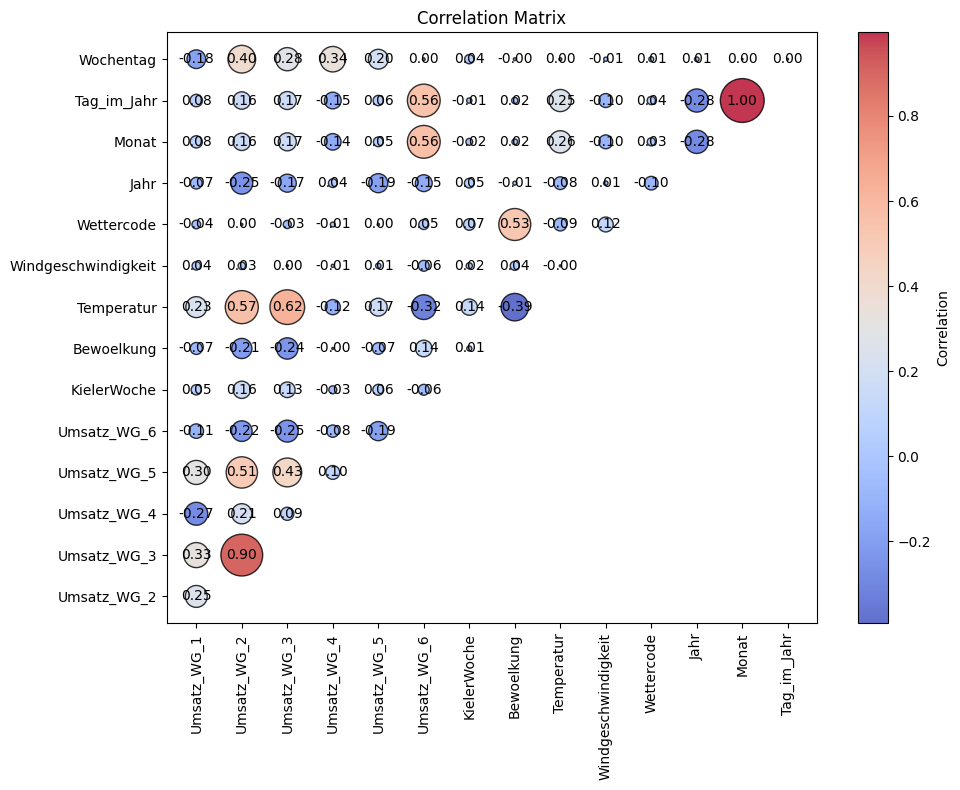

In [87]:
# Compute correlation matrix
corr = merged_df.select_dtypes(include='number').corr()

# Mask lower triangle
mask = np.tril(np.ones_like(corr, dtype=bool))
corr_masked = corr.mask(mask)

# Melt to long-form DataFrame
corr_long = corr_masked.reset_index().melt(id_vars='index')
corr_long.columns = ['Var1', 'Var2', 'Correlation']
corr_long.dropna(inplace=True)

# Plot
plt.figure(figsize=(10, 8))
bubble = plt.scatter(
    x=corr_long['Var1'],
    y=corr_long['Var2'],
    s=np.abs(corr_long['Correlation']) * 1000,  # bubble size
    c=corr_long['Correlation'],
    cmap='coolwarm',
    edgecolor='black',
    alpha=0.8
)

# Add text labels
for i in range(len(corr_long)):
    plt.text(
        corr_long['Var1'].iloc[i],
        corr_long['Var2'].iloc[i],
        f"{corr_long['Correlation'].iloc[i]:.2f}",
        ha='center', va='center', color='black'
    )

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Correlation Matrix")
plt.colorbar(bubble, label='Correlation')
plt.grid(False)
plt.tight_layout()
plt.show()


